In [55]:

from foundry.env import Environment
import matplotlib.pyplot as plt
from functools import partial
import scipy
from foundry.core.transforms import jit
from typing import Any, Generic, Optional, Sequence
from foundry.core.dataclasses import dataclass, field
from foundry.env.core import EnvWrapper, ObserveConfig, RenderConfig, \
    State, ReducedState, Action, Observation, Render, Environment
import jax
import foundry.core as F
import jax.numpy as jnp

@dataclass
class TimedState(Generic[State]):
    internal : State
    #side_info : Any = None

    timestep :jax.Array = field(default_factory=lambda: jnp.zeros((), dtype=jnp.uint32))

    def is_before(self,t):
        return t <= self.timestep

    
"""
@dataclass
class TimedEnvWrapper(EnvWrapper):
    time_limit : jax.Array = field(default_factory=lambda: jnp.zeros((), dtype=jnp.uint32))


    def sample_state(self, rng_key : F.Array) -> State:
        return TimedState(self.base.sample_state(rng_key))

    def sample_action(self, rng_key : F.Array) -> Action:
        return self.base.sample_action(rng_key)

    def reset(self, rng_key : F.Array) -> State:
        return TimedState(self.base.reset(rng_key))

    def step(self, state : TimedState, action : Action,
             rng_key : Optional[F.Array] = None) -> State:
        return TimedState(self.base.step(state.internal, action, rng_key), state.timestep + 1)

    def observe(self, state: TimedState,
            config: ObserveConfig[Observation] | None = None) -> Observation:
        return self.base.observe(state.internal, config)

    def reward(self, state: TimedState,
               action : Action, next_state : State) -> F.Array:
        return self.base.reward(state.internal, action, next_state)

    def cost(self, states: TimedState, actions: Action) -> F.Array:
        return self.base.cost(states.internal, actions)

    def is_finished(self, state: TimedState) -> F.Array:
        is_finished = self.base.is_finished(state.internal) 
        is_finished = jnp.logcal_or(is_finished, jnp.logical_and(self.time_limit != 0,\
            state.time_limit <= state.timestep))
        return is_finished

    def render(self, state : TimedState,
               config: RenderConfig[Render] | None = None) -> Render:
        return self.base.render(state.internal, config)

    def __getattr__(self, name):
        return getattr(self.base, name)
"""

# environment that specifies a list of environemnts, 
# as well as a mechanism, for switching between them 
@dataclass
class StitchedEnvironment(Environment):

    envs_list : Sequence[Environment]

    @property
    def base(self):
        return self.envs_list[0]
    
    @property
    def num_envs(self):
        return len(self.envs_list)

    def get_index(self, state : State):
        return state.timestep+1, state.timestep % len(self.envs_list)
  
    def full_state(self, reduced_state: ReducedState) -> State:
        raise Exception("function not supported")
        #return self.base.full_state(reduced_state)
    def reduce_state(self, full_state: State) -> ReducedState:
        raise Exception("function not supported")

    def sample_state(self, rng_key : F.Array) -> State:
        return TimedState(self.base.sample_state(rng_key))
    
    def sample_action(self, rng_key : F.Array) -> Action:
        return self.base.sample_action(rng_key)

    def reset(self, rng_key : F.Array) -> State:
        return TimedState(self.base.reset(rng_key))

    def step(self, state : TimedState, action : Action,
             rng_key : Optional[F.Array] = None) -> State:
        t_next,index = self.get_index(state) 
        steps = [(partial(self.envs_list[i].step, action=action, rng_key=rng_key)) \
                               for i in range(self.num_envs)]
       
        next_state = jax.lax.switch(index, steps, state.internal)
        return TimedState(next_state, timestep = t_next)

    def observe(self, state: TimedState,
            config: ObserveConfig[Observation] | None = None) -> Observation:
        return self.base.observe(state.internal, config)

    def reward(self, state: TimedState,
               action : Action, next_state : State) -> F.Array:
        return self.base.reward(state.internal, action, next_state)

    def cost(self, states: TimedState, actions: Action) -> F.Array:
        return self.base.cost(states.internal, actions)

    def is_finished(self, state: TimedState) -> F.Array:
        is_finished = self.base.is_finished(state.internal) 
        is_finished = jnp.logcal_or(is_finished, jnp.logical_and(self.time_limit != 0,\
            state.time_limit <= state.timestep))
        return is_finished

    def render(self, state : TimedState,
               config: RenderConfig[Render] | None = None) -> Render:
        return self.base.render(state.internal, config)

    def __getattr__(self, name):
        return getattr(self.base, name)

"""
@dataclass
class StitchedTimedEnvironment(Environment):

    envs_list = Sequence[Environment]

    @property
    def base(self):
        return self.envs_list[0]

    @property
    def num_envs(self):
        return len(self.envs_list)

    def get_index(self, timestep : jax.Array):
        return timestep % len(self.envs_list)
  
    def full_state(self, reduced_state: ReducedState) -> State:
        raise Exception("function not supported")
        #return self.base.full_state(reduced_state)
    def reduce_state(self, full_state: State) -> ReducedState:
        raise Exception("function not supported")

    def sample_state(self, rng_key : F.Array) -> State:
        return TimedState(self.base.sample_state(rng_key))
    
    def sample_action(self, rng_key : F.Array) -> Action:
        return self.base.sample_action(rng_key)

    def reset(self, rng_key : F.Array) -> State:
        return TimedState(self.base.reset(rng_key))

    def step(self, state : TimedState, action : Action,
             rng_key : Optional[F.Array] = None) -> State:
        index = self.get_index(state.timestep) 
        print(index)
        length = len(self.envs_list)
        next_state = jax.lax.switch(index, [lambda: self.envs_list[i].step(state, action, rng_key) \
                               for i in range(self.num_envs)])
        return next_state

    def observe(self, state: TimedState,
            config: ObserveConfig[Observation] | None = None) -> Observation:
        return self.base.observe(state, config)

    def reward(self, state: TimedState,
               action : Action, next_state : State) -> F.Array:
        return self.base.reward(state, action, next_state)

    def cost(self, states: TimedState, actions: Action) -> F.Array:
        return self.base.cost(states, actions)

    def is_finished(self, state: TimedState) -> F.Array:
        is_finished = self.base.is_finished(state) 
        is_finished = jnp.logcal_or(is_finished, jnp.logical_and(self.time_limit != 0,\
            state.time_limit <= state.timestep))
        return is_finished

    def render(self, state : TimedState,
               config: RenderConfig[Render] | None = None) -> Render:
        return self.base.render(state, config)

    def __getattr__(self, name):
        return getattr(self.base, name)
    
"""
    

'\n@dataclass\nclass StitchedTimedEnvironment(Environment):\n\n    envs_list = Sequence[Environment]\n\n    @property\n    def base(self):\n        return self.envs_list[0]\n\n    @property\n    def num_envs(self):\n        return len(self.envs_list)\n\n    def get_index(self, timestep : jax.Array):\n        return timestep % len(self.envs_list)\n  \n    def full_state(self, reduced_state: ReducedState) -> State:\n        raise Exception("function not supported")\n        #return self.base.full_state(reduced_state)\n    def reduce_state(self, full_state: State) -> ReducedState:\n        raise Exception("function not supported")\n\n    def sample_state(self, rng_key : F.Array) -> State:\n        return TimedState(self.base.sample_state(rng_key))\n    \n    def sample_action(self, rng_key : F.Array) -> Action:\n        return self.base.sample_action(rng_key)\n\n    def reset(self, rng_key : F.Array) -> State:\n        return TimedState(self.base.reset(rng_key))\n\n    def step(self, stat

In [56]:
class LinearSystem(Environment):
    def __init__(self, A, B, Q=None, R=None,
                x0_min=None, x0_max=None,
                x_max=None, x_min=None,
                u_max=None, u_min=None):
        self.A = A
        self.B = B

        self.Q = Q if Q is not None else jnp.eye(A.shape[0])
        self.R = R if R is not None else jnp.eye(B.shape[1])
        self.P = jnp.array(scipy.linalg.solve_discrete_are(self.A, self.B, self.Q, self.R,
                                              e=None, s=None, balanced=True), dtype=jnp.float32)
        self.x_min = x_min
        self.x_max = x_max
        self.u_min = u_min
        self.u_max = u_max
        self.x0_min = x0_min if x0_min is not None else x_min
        self.x0_max = x0_max if x0_max is not None else x_max

    def sample_action(self, rng):
        min = self.u_min if self.u_min is not None else -1
        max = self.u_max if self.u_max is not None else 1
        return jax.random.uniform(rng, (self.B.shape[1],), jnp.float32, min, max)

    def sample_state(self, key):
        min = self.x_min if self.x_min is not None else -1
        max = self.x_max if self.x_max is not None else 1
        return jax.random.uniform(key, (self.A.shape[0],), jnp.float32, min, max)
    
    def reset(self, key):
        min = self.x0_min if self.x0_min is not None else -1
        max = self.x0_max if self.x0_max is not None else 1
        return jax.random.uniform(key, (self.A.shape[0],), jnp.float32, min, max)
    
    def step(self, state, action, rng_key = None):
        if action is None:
            x = self.A @ jnp.expand_dims(state, -1)
        else:
            action = jnp.atleast_1d(action)
            x = self.A @ jnp.expand_dims(state, -1) + self.B @ jnp.expand_dims(action, -1)
        return jnp.squeeze(x, -1)

    def cost(self, xs, us):
        x_cost = jnp.expand_dims(xs,-2) @ self.Q @ jnp.expand_dims(xs,-1)
        u_cost = jnp.expand_dims(us,-2) @ self.R @ jnp.expand_dims(us, -1)
        xf_cost = jnp.expand_dims(xs[-1],-2) @ self.P @ jnp.expand_dims(xs[-1],-1)
        return jnp.sum(x_cost) + jnp.sum(u_cost) + jnp.sum(xf_cost)







                  

In [57]:
from typing import List

@jit
def indicator(x : jnp.array, y : jnp.array):
    out =  jnp.maximum(x - y + 1, 0)
    return jnp.maximum(2*out-1,0)

def make_scalar_switching(L = -1, H = 10):
    envs = []
    for i in range(10):
        sign = 2*((i % 2))-1
        sys = LinearSystem(A=jnp.array([[-1*sign]]), B=jnp.array([[1]]))
        envs.append(sys)
    return envs 
envs = make_scalar_switching()

switched = StitchedEnvironment(envs_list = envs)
key = jax.random.key(0)
state = switched.sample_state(rng_key=key)



In [58]:
key = jax.random.key(0)
state_one = switched.sample_state(rng_key=key)
 #switched.reset(key)
#print(state_one)
state = state_one

state = jax.lax.fori_loop(0, 13,  lambda x, y: switched.step(y,action = None),state)
    #state = switched.step(state, action = None)
#print(state)

In [59]:
"""TODO: Switched Policy"""


'TODO: Switched Policy'

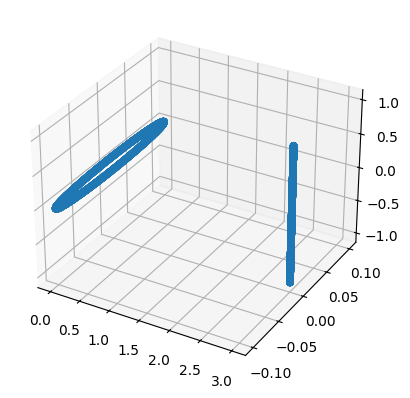

In [60]:

import typing 
Distribution = typing.TypeVar("Distribution")



def sample_sphere( key : F.Array, radius=1, dim =2):
        """Generate n points uniformly sampled within a sphere of given radius."""

        key1, key2 = jax.random.split(key)
        # Generate random directions
        direction = jax.random.normal(key1, (dim,))
        direction = direction/ jnp.linalg.norm(direction, keepdims=True) 
        return radius*direction
def sample_ball( key : F.Array, radius=1, dim =2):
        return radius*jax.random.ball(key, d=dim)


def stable_construction_sample(key : F.Array, offset = 3., Delta = .1, dim =2):
        key1,key2,key3 = jax.random.split(key,3)
        Z = jax.random.bernoulli(key1)
        x1 = jnp.pad(sample_ball(key2,radius = 1,dim = dim-2),(2,0)) + offset*jax.nn.one_hot(0,dim)
        x2 = jnp.pad(sample_sphere(key3,radius = Delta,dim = dim-1),(1,0))
        return (1. -Z) * x1 + (Z + 0.)*x2

def test_sphere_sample():
        key = jax.random.key(0)
        keys = jax.random.split(key, 10000)
        samples = jax.vmap(lambda x: sample_sphere(x,dim=3))(keys)
        samples = jnp.transpose(samples)
        #plt.scatter3d(samples[0,:], samples[1,:],samples[2,:])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(samples[0,:], samples[1,:], samples[2,:])
        plt.show

def test_stable_construction_sample():
        key = jax.random.key(0)
        keys = jax.random.split(key, 10000)
        samples = jax.vmap(lambda x: stable_construction_sample(x,dim=3))(keys)
        samples = jnp.transpose(samples)
        #plt.scatter3d(samples[0,:], samples[1,:],samples[2,:])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(samples[0,:], samples[1,:], samples[2,:])
        plt.show

test_stable_construction_sample()

In [61]:
"""Padded Hard Matrices"""

def makeApad( i : int, mu : float = .25, dim :int = 2):
    mu = mu + 0.
    c_mu = 1.5 * mu
    if i == 1:
        A =jnp.array([[1+mu,c_mu],
                      [-1. * c_mu, 1 - 2.*mu]])
    else:
        A=jnp.array([[-1.*(1. - (.25*mu)),c_mu],
                     [0., 1 - 2.*mu]])

    return jnp.pad(A,((0,dim-2),(0,dim-2)))

def makeKpad( i : int, mu : float = .25, dim :int = 2):
    mu = mu + 0.
    c_mu = 1.5 * mu
    if i == 1:
        K =jnp.array([[-1.*(1+mu),-1.*c_mu],
                      [c_mu, 0.]])
    else:
        K=jnp.array([[(1. - (.25*mu)),-1.*c_mu],
                     [0., 0.]])
        
    return jnp.pad(K,((0,dim-2),(0,dim-2)))


A = makeApad(2, dim=4)
K = makeKpad(1,dim=4)


"""Bump Functions"""

'Bump Functions'

In [62]:
"""Unstable System"""


    

### Environment using a specified function 
### and distribution, with other functionality accounted for
### cost is square of e1 value
@dataclass
class FirstStepEnvironment(Environment):
    #base_fn : OneStepFn
    
    dim_d : int
    model : callable

   
    @property
    def e1(self):
        return jax.nn.one_hot(0,self.dim_d)
    

    def sample_state(self, rng_key : F.Array) -> State:
        return self.reset(rng_key)

    def sample_action(self, rng_key : F.Array) -> Action:
        return sample_sphere(rng_key,self.dim_d)

    def reset(self, rng_key : F.Array) -> State:
        return NotImplementedError()

    def step(self, state : State, action : Action,
             rng_key : Optional[F.Array] = None) -> State:
        return action 
            
    def observe(self, state: State,
            config: ObserveConfig[Observation] | None = None) -> Observation:
        return state

    def reward(self, state: State,
               action : Action, next_state : State) -> F.Array:
        return -jnp.square(jnp.dot(self.e1,state))

    def cost(self, states: State, actions: Action) -> F.Array:
        return jnp.square(jnp.dot(self.e1,states))

    def is_finished(self, state: State) -> F.Array:
        return False

    def render(self, state : State,
               config: RenderConfig[Render] | None = None) -> Render:
        raise NotImplementedError()


def sample_ball( key : F.Array, radius=1, dim =2):
        return radius*jax.random.ball(key, d=dim)



@dataclass
class FirstStepUnstableEnvironment(FirstStepEnvironment):  
    dim_k : int
    offset : float = 3.
    
    def pad_last(self,x):
        return jnp.pad(x, (0,self.dim_d-self.dim_k))
    
    def project_first(self,x):
        return x[0:self.dim_k]
    
    def reset(self, rng_key : F.Array) -> State:
        return self.offset *self.e1 + self.pad_last(jax.random.ball(rng_key, d=self.dim_k))
    
    def step(self, state : State, action : Action,
             rng_key : Optional[F.Array] = None) -> State:
        return action - self.model(self.project_first(state))*self.e1

@dataclass
class FirstStepStableEnvironment(FirstStepEnvironment):  
    tau : float = .25
    Delta : float = .1
    offset : float = 3.
    omega : float = .3

    def project_last(self,x):
        return x[2:]

    def reset(self, rng_key : F.Array) -> State:
        key1,key2,key3 = jax.random.split(rng_key,3)
        Z = jax.random.bernoulli(key1)
        x1 = jnp.pad(sample_ball(key2,radius = 1,dim = self.dim_d-2),(2,0)) \
            + self.offset*self.e1
        x2 = jnp.pad(sample_sphere(key3,radius = self.Delta,dim = self.dim_d-1),(1,0))
        return (1. -Z) * x1 + (Z + 0.)*x2
    
    def step(self, state : State, action : Action,
             rng_key : Optional[F.Array] = None) -> State:
        model_val = self.model(self.project_last(state))
        #print('model_val' , model_val)
        return action + (self.omega * self.tau) * self.e1 * (model_val - jnp.dot(self.e1,action))
    

model = lambda x: jnp.sum(x)
env = FirstStepUnstableEnvironment(dim_d = 10, dim_k = 5, model=model)
key = jax.random.key(0)
zero_action = jnp.zeros(10)
zero_action = zero_action.at[9].set(1)
ones_state = jnp.ones(10)
print(zero_action[-3:])



[0. 0. 1.]


In [ ]:
import flax.linen as nn
import jax.flatten_util

from functools import partial
from foundry.util.registry import Registry


class MLPPredictor(nn.Module):
    d_output: int
    features: Sequence[int] = (64, 64, 64)

    def h(self,x):
        return x * jax.nn.sigmoid(x)
    
    @nn.compact
    def __call__(self, x):
        x, _ = jax.flatten_util.ravel_pytree(x)
        Dense = partial(nn.Dense, kernel_init = nn.initializers.lecun_normal(),
                         bias_init = nn.initializers.uniform())
        for i, f in enumerate(self.features):
            x = Dense(f)(x)
            x = self.h(x)
        x = Dense(self.d_output)(x)
        return x

  
MLPSmall = partial(MLPPredictor, features=[320, 320],d_output=1)
model = MLPSmall()
key = jax.random.key(7)
input = jnp.zeros(5,)
params = model.init(key,input)
input = jax.random.normal(key,(5,))
print(print(model.apply(params,input)))



[0.23724598]
None


In [64]:
#mylist = [1]
#mylist.extend([2,3])
#print(mylist)

a = jax.lax.cond(True, lambda : 5, lambda : 10)
print(a)

5


In [66]:
## An environment which always plays envzero, then switches between 
# remaining n_swtich envs
@dataclass
class OnePlusNStitchedEnvironment(StitchedEnvironment):
    n_switch : int 

    @property
    def num_envs(self):
        return 1 + self.n_switch

    def get_index(self, state : State):
        t = state.timestep
        is_zero = jnp.minimum(t,1) 
        return t+1,is_zero * (((t - 1) % self.n_switch)+1)
    

def create_unstable(dim_d: int, dim_k: int, nn_features : list = [32,32],
    d_output : int = 1, offset : float = 3., rho : float = 2., flag :str= 'fixed',n_total :int = 10):
    model = MLPPredictor(features=nn_features,d_output=d_output)
    params = model.init(key,jnp.zeros(dim_k))
    model_apply = lambda x: model.apply(params, x)
    first_env = FirstStepUnstableEnvironment(dim_d = dim_d, dim_k = dim_k, model=model_apply,offset=offset)
    envs_list = [first_env]
    B = jnp.eye(dim_d)
    if flag == 'fixed': 
        n_switch = 1
        A = rho*B
        envs_list.append(LinearSystem(A=A,B=B))
    if flag == 'alternate': 
        n_switch = 2
        A = rho*B
        envs_list.extend([LinearSystem(A=A,B=B),LinearSystem(A=-1*A,B=B)])

    env= OnePlusNStitchedEnvironment(envs_list=envs_list, n_switch = n_switch)
    policy = #TODO

def create_stable(dim_d: int, nn_features : list = [32,32],
    d_output : int = 1, mu : float = .25, omega : float = 1, Delta : float = .1, 
    tau : float = .25, offset:float = 3., index : int = 1):
    
    model = MLPPredictor(features=nn_features,d_output=d_output)
    params = model.init(key,jnp.zeros(dim_d-2))
    model_apply = lambda x: model.apply(params, x)
    first_env = FirstStepStableEnvironment(dim_d = dim_d, tau=tau, Delta=Delta, 
                                           omega=omega, offset=offset, model=model_apply)
    envs_list = [first_env]
    B = jnp.eye(dim_d)
    A = makeApad(i=index,mu=mu,dim=dim_d)
    envs_list.append(LinearSystem(A,B))

    class CustomEnvironment(OnePlusNStitchedEnvironment):
        def get_index(self, state : State):
            (t_next, index) = super().get_index(state=state)
            internal = state.internal
            cond = (internal[1] !=0.) and  (internal[0] ==0.) 
            index = jax.lax.cond(cond,lambda : jnp.ones_like(index) , lambda : index)
            print('cond', cond)
            print('index', index)
            print('t_next', t_next)
            return (t_next, index)

    env= CustomEnvironment(envs_list=envs_list, n_switch = 1)
    policy = #TODO



def test(flag:str = 'stable',len_test = 3, key_num=4):
    if flag == 'stable':
        env, policy = create_stable(dim_d=5,omega=0)
    else: 
        env = create_unstable_environment(dim_d=5, dim_k =2,flag='alternate')
    key = jax.random.key(key_num)
    #print(env.sample_action(key))
    x1 = env.sample_state(key)
    action = jnp.zeros(5)
    print(x1)
    x = x1
    print('loop starting')
    for i in range(len_test):
        print('xbefore', x)
        x = env.step(x,action)
        print('xafter', x)
    


#print(env.envs_list[0].A)
    #print(env.envs_list[1].A)
    #fn0 = lambda x: env.envs_list[0].step(x, action, rng_key=None)
    #fn1 = lambda x: env.envs_list[1].step(x, action, rng_key=None)

        #print('num_envs', self.num_envs)
        #print('index', index)
    #print('steps', state.internal, [step(state.internal) for step in steps])
    
    #print(x1)
    #print(env.envs_list[0].step(x1.internal,action))
    #print(env.envs_list[1
    #].step(x1.internal,action))

test(flag='stable',len_test=3,key_num=1)



[FirstStepStableEnvironment(dim_d=5, model=<function create_stable_environment.<locals>.<lambda> at 0x7c54d156a840>, tau=0.25, Delta=0.1, offset=3.0, omega=0), <__main__.LinearSystem object at 0x7c54d1577230>]
TimedState(internal=Array([0.        , 0.004114  , 0.00477154, 0.0967496 , 0.02449126],      dtype=float32), timestep=Array(0, dtype=uint32))
loop starting
xbefore TimedState(internal=Array([0.        , 0.004114  , 0.00477154, 0.0967496 , 0.02449126],      dtype=float32), timestep=Array(0, dtype=uint32))
cond True
index 1
t_next 1
xafter TimedState(internal=Array([0.00154275, 0.002057  , 0.        , 0.        , 0.        ],      dtype=float32), timestep=Array(1, dtype=uint32))
xbefore TimedState(internal=Array([0.00154275, 0.002057  , 0.        , 0.        , 0.        ],      dtype=float32), timestep=Array(1, dtype=uint32))
cond False
index 1
t_next 2
xafter TimedState(internal=Array([0.00269981, 0.00044997, 0.        , 0.        , 0.        ],      dtype=float32), timestep=Array